### Training RL Policies using L5Kit Closed-Loop Environment

This notebook describes how to train RL policies for self-driving using our gym-compatible closed-loop environment.

We will be using [Proximal Policy Optimization (PPO)](https://arxiv.org/abs/1707.06347) algorithm as our reinforcement learning algorithm, as it not only demonstrates remarkable performance but it is also empirically easy to tune.

The PPO implementation in this notebook is based on [Stable Baselines3](https://github.com/DLR-RM/stable-baselines3) framework, a popular framework for training RL policies. Note that our environment is also compatible with [RLlib](https://docs.ray.io/en/latest/rllib.html), another popular frameworks for the same.

ref: 
([rllib] Best workflow to train, save, and test agent #9123
)[https://github.com/ray-project/ray/issues/9123]

In [2]:
import os
os.environ["L5KIT_DATA_FOLDER"] = '/workspace/datasets'
os.environ['CUDA_VISIBLE_DEVICES']= '1'

In [3]:
import gym

# from stable_baselines3 import PPO
# from stable_baselines3.common.callbacks import CheckpointCallback
# from stable_baselines3.common.env_util import make_vec_env
# from stable_baselines3.common.utils import get_linear_fn
# from stable_baselines3.common.vec_env import SubprocVecEnv

from l5kit.configs import load_config_data
# from l5kit.environment.feature_extractor import CustomFeatureExtractor
# from l5kit.environment.callbacks import L5KitEvalCallback
from l5kit.environment.envs.l5_env import SimulationConfigGym, GymStepOutput, L5Env

from l5kit.visualization.visualizer.zarr_utils import episode_out_to_visualizer_scene_gym_cle
from l5kit.visualization.visualizer.visualizer import visualize
from bokeh.io import output_notebook, show
from l5kit.environment.gym_metric_set import L2DisplacementYawMetricSet, CLEMetricSet
from prettytable import PrettyTable
import datetime
from ray.rllib.models import ModelCatalog
from ray.rllib.models.torch.torch_modelv2 import TorchModelV2
import torch.nn as nn
import numpy as np
import gym
from typing import Dict
import numpy as np
import ray
import pytz


## Init ray and env

In [4]:
# Dataset is assumed to be on the folder specified
# in the L5KIT_DATA_FOLDER environment variable
from l5kit.configs import load_config_data

# get environment config
env_config_path = 'src/configs/gym_config84.yaml'
cfg = load_config_data(env_config_path)


In [ ]:


ray.init(num_cpus=5, ignore_reinit_error=True, log_to_driver=False)

## Customize my model
SAC: https://github.com/ray-project/ray/blob/dfb9689701361cfd18f383e0a3edeed6baf81abb/rllib/agents/sac/sac_torch_model.py

## Define Training and Evaluation Environments

**Training**: We will be training the PPO policy on episodes of length 32 time-steps. We will have 4 sub-processes (training environments) that will help to parallelize and speeden up episode rollouts. The *SimConfig* dataclass will define the parameters of the episode rollout: like length of episode rollout, whether to use log-replayed agents or simulated agents etc.

**Evaluation**: We will evaluate the performance of the PPO policy on the *entire* scene (~248 time-steps).

## Customize gym env

In [ ]:
# class L5EnvWrapper(gym.Wrapper):
#     def __init__(self, env, raster_size = 112, n_channels = 7):
#         super().__init__(env)
#         self.env = env
#         self.n_channels = n_channels
#         self.raster_size = raster_size
#         obs_shape = (self.raster_size, self.raster_size, self.n_channels)
#         self.observation_space =gym.spaces.Box(low=0, high=1, shape=obs_shape, dtype=np.float32)

#     def step(self, action:  np.ndarray) -> GymStepOutput:
#         # return GymStepOutput(obs, reward["total"], done, info)
#         output =  self.env.step(action)
#         onlyImageState = output.obs['image'].reshape(self.raster_size, self.raster_size, self.n_channels)
#         return GymStepOutput(onlyImageState, output.reward, output.done, output.info)

#     def reset(self) -> Dict[str, np.ndarray]:
#         return self.env.reset()['image'].reshape(self.raster_size, self.raster_size, self.n_channels)


In [ ]:
from src.customEnv.wrapper import L5EnvWrapper, L5EnvWrapperTorch
from ray import tune
train_eps_length = 32
train_sim_cfg = SimulationConfigGym()
train_sim_cfg.num_simulation_steps = train_eps_length + 1
# Register , how your env should be constructed (always with 5, or you can take values from the `config` EnvContext object):
env_kwargs = {'env_config_path': env_config_path, 'use_kinematic': True, 'sim_cfg': train_sim_cfg}

tune.register_env("L5-CLE-V0", lambda config: L5Env(**env_kwargs))
tune.register_env("L5-CLE-V1", lambda config: L5EnvWrapperTorch(env = L5Env(**env_kwargs), \
                                                           raster_size= cfg['raster_params']['raster_size'][0], \
                                                           n_channels = 7))

## Train

import numpy as np

import ray
from ray import air, tune
from ray.air import session
from ray.air.integrations.wandb import setup_wandb
from ray.air.integrations.wandb import WandbLoggerCallback
os.environ['WANDB_NOTEBOOK_NAME'] = '/DATA/rllib_ppo_policy_training.ipynb'!wandb login 083592c84134c040dcca598c644c348d32540a08
import wandb ## ref

Resume stop tune: https://docs.ray.io/en/latest/tune/tutorials/tune-stopping.html

tune.Tuner analysis: https://docs.ray.io/en/latest/rllib/rllib-training.html#basic-python-api

get best result, load from dir: https://docs.ray.io/en/master/tune/examples/tune_analyze_results.html#trial-level-analysis-working-with-an-individual-result

In [ ]:
!wandb login 083592c84134c040dcca598c644c348d32540a08

In [ ]:
import numpy as np

import ray
from ray import air, tune
from ray.air import session
from ray.air.integrations.wandb import setup_wandb
from ray.air.integrations.wandb import WandbLoggerCallback
os.environ['WANDB_NOTEBOOK_NAME'] = '/DATA/rllib_sac_policy_training.ipynb'

In [ ]:
import wandb
wandb.init(project="l5kit2", reinit = True)

In [ ]:
import ray
from ray import air, tune
train_envs = 4
newYorkTz = pytz.timezone("Asia/Ho_Chi_Minh") 
date = datetime.datetime.now(newYorkTz).strftime("%d-%m-%Y_%H-%M-%S")
ray_result_logdir = '/workspace/datasets/ray_results/debug_' + date

lr = 3e-3
lr_start = 3e-4
lr_end = 3e-5
config_param_space = {
    "env": "L5-CLE-V1",
    "framework": "torch",
    "num_gpus": 1,
    "num_workers": 8, # 63
    "num_envs_per_worker": train_envs,
    'q_model_config' : {
            # "dim": 112,
            # "conv_filters" : [[64, [7,7], 3], [32, [11,11], 3], [32, [11,11], 3]],
            # "conv_activation": "relu",
            "post_fcnet_hiddens": [256],
            "post_fcnet_activation": "relu",
        },
    'policy_model_config' : {
            # "dim": 112,
            # "conv_filters" : [[64, [7,7], 3], [32, [11,11], 3], [32, [11,11], 3]],
            # "conv_activation": "relu",
            "post_fcnet_hiddens": [256],
            "post_fcnet_activation": "relu",
        },
    'tau': 0.005,
    'target_network_update_freq': 1,
    'replay_buffer_config':{
        'type': 'MultiAgentPrioritizedReplayBuffer',
        'capacity': int(1e4), #int(1e5)
        "worker_side_prioritization": True,
    },
    'num_steps_sampled_before_learning_starts': 2048, # 8000,
    
    'target_entropy': 'auto',
#     "model": {
#         "custom_model": "GN_CNN_torch_model",
#         "custom_model_config": {'feature_dim':128},
#     },
    '_disable_preprocessor_api': True,
     "eager_tracing": True,
     "restart_failed_sub_environments": True,
 
    # 'train_batch_size': 4000,
    # 'sgd_minibatch_size': 256,
    # 'num_sgd_iter': 16,
    # 'store_buffer_in_checkpoints' : False,
    'seed': 42,
    'batch_mode': 'truncate_episodes',
    "rollout_fragment_length": 1,
    'train_batch_size': 256, # 2048
    'training_intensity' : 32, # (4x 'natural' value = 8) 'natural value = train_batch_size / (rollout_fragment_length x num_workers x num_envs_per_worker) = 256 / 1x 8 x 4 = 8
    'gamma': 0.8,
    'twin_q' : True,
    "lr": 3e-4,
    "min_sample_timesteps_per_iteration": 2048, # 8000
}

result_grid = tune.Tuner(
    "SAC",
    run_config=air.RunConfig(
        stop={"episode_reward_mean": 0, 'timesteps_total': int(6e6)},
        local_dir=ray_result_logdir,
        checkpoint_config=air.CheckpointConfig(num_to_keep=2, checkpoint_frequency = 10, checkpoint_score_attribute = 'episode_reward_mean')
        ),
    param_space=config_param_space).fit()

In [ ]:
import ray
from ray import air, tune
train_envs = 4

hcmTz = pytz.timezone("Asia/Ho_Chi_Minh") 
date = datetime.datetime.now(hcmTz).strftime("%d-%m-%Y_%H-%M-%S")
ray_result_logdir = '/DATA/l5kit/ray_results/' + date

lr = 3e-3
lr_start = 3e-4
lr_end = 3e-5
config_param_space = {
    "env": "L5-CLE-V1",
    "framework": "torch",
    "num_gpus": 1,
    "num_workers": 63,
    "num_envs_per_worker": train_envs,
    'q_model_config' : {
            # "dim": 112,
            # "conv_filters" : [[64, [7,7], 3], [32, [11,11], 3], [32, [11,11], 3]],
            # "conv_activation": "relu",
            "post_fcnet_hiddens": [256],
            "post_fcnet_activation": "relu",
        },
    'policy_model_config' : {
            # "dim": 112,
            # "conv_filters" : [[64, [7,7], 3], [32, [11,11], 3], [32, [11,11], 3]],
            # "conv_activation": "relu",
            "post_fcnet_hiddens": [256],
            "post_fcnet_activation": "relu",
        },
    'tau': 0.005,
    'target_network_update_freq': 1,
    'replay_buffer_config':{
        'type': 'MultiAgentPrioritizedReplayBuffer',
        'capacity': int(1e5),
        "worker_side_prioritization": True,
    },
    'num_steps_sampled_before_learning_starts': 8000,
    
    'target_entropy': 'auto',
#     "model": {
#         "custom_model": "GN_CNN_torch_model",
#         "custom_model_config": {'feature_dim':128},
#     },
    '_disable_preprocessor_api': True,
     "eager_tracing": True,
     "restart_failed_sub_environments": True,
 
    # 'train_batch_size': 4000,
    # 'sgd_minibatch_size': 256,
    # 'num_sgd_iter': 16,
    # 'store_buffer_in_checkpoints' : False,
    'seed': 42,
    'batch_mode': 'truncate_episodes',
    "rollout_fragment_length": 1,
    'train_batch_size': 2048,
    'training_intensity' : 32, # (4x 'natural' value = 8)
    'gamma': 0.8,
    'twin_q' : True,
    "lr": 3e-4,
    "min_sample_timesteps_per_iteration": 8000,
}

result_grid = tune.Tuner(
    "SAC",
    run_config=air.RunConfig(
        stop={"episode_reward_mean": 0, 'timesteps_total': int(4e6)},
        local_dir=ray_result_logdir,
        checkpoint_config=air.CheckpointConfig(num_to_keep=2, checkpoint_frequency = 10, checkpoint_score_attribute = 'episode_reward_mean'),
        callbacks=[WandbLoggerCallback(project="l5kit2", 
						save_checkpoints=True),],
        ),
        
    param_space=config_param_space).fit()

In [ ]:
import ray
from ray import air, tune
train_envs = 4

hcmTz = pytz.timezone("Asia/Ho_Chi_Minh") 
date = datetime.datetime.now(hcmTz).strftime("%d-%m-%Y_%H-%M-%S")
ray_result_logdir = '/DATA/l5kit/ray_results/' + date

lr = 3e-3
lr_start = 3e-4
lr_end = 3e-5
config_param_space = {
    "env": "L5-CLE-V1",
    "framework": "torch",
    "num_gpus": 1,
    "num_workers": 63,
    "num_envs_per_worker": train_envs,
    'q_model_config' : {
            # "dim": 112,
            # "conv_filters" : [[64, [7,7], 3], [32, [11,11], 3], [32, [11,11], 3]],
            # "conv_activation": "relu",
            "post_fcnet_hiddens": [256],
            "post_fcnet_activation": "relu",
        },
    'policy_model_config' : {
            # "dim": 112,
            # "conv_filters" : [[64, [7,7], 3], [32, [11,11], 3], [32, [11,11], 3]],
            # "conv_activation": "relu",
            "post_fcnet_hiddens": [256],
            "post_fcnet_activation": "relu",
        },
    'tau': 0.005,
    'target_network_update_freq': 1,
    'replay_buffer_config':{
        'type': 'MultiAgentPrioritizedReplayBuffer',
        'capacity': int(1e5),
        "worker_side_prioritization": True,
    },
    'num_steps_sampled_before_learning_starts': 8000,
    
    'target_entropy': 'auto',
#     "model": {
#         "custom_model": "GN_CNN_torch_model",
#         "custom_model_config": {'feature_dim':128},
#     },
    '_disable_preprocessor_api': True,
     "eager_tracing": True,
     "restart_failed_sub_environments": True,
 
    # 'train_batch_size': 4000,
    # 'sgd_minibatch_size': 256,
    # 'num_sgd_iter': 16,
    # 'store_buffer_in_checkpoints' : False,
    'seed': 42,
    'batch_mode': 'truncate_episodes',
    "rollout_fragment_length": 1,
    'train_batch_size': 2048,
    # 'training_intensity' : 1000,
    'gamma': 0.8,
    'twin_q' : True,
    "lr": 3e-4,
    "min_sample_timesteps_per_iteration": 8000,
}

result_grid = tune.Tuner(
    "SAC",
    run_config=air.RunConfig(
        stop={"episode_reward_mean": 0, 'timesteps_total': int(2e6)},
        local_dir=ray_result_logdir,
        checkpoint_config=air.CheckpointConfig(num_to_keep=2, checkpoint_frequency = 10, checkpoint_score_attribute = 'episode_reward_mean')
        ),
    param_space=config_param_space).fit()

In [ ]:
config_param_space = {
    "env": "L5-CLE-V1",
    "framework": "torch",
    "num_gpus": 1,
    "num_workers": 63,
    "num_envs_per_worker": train_envs,
    'q_model_config' : {
            # "dim": 112,
            # "conv_filters" : [[64, [7,7], 3], [32, [11,11], 3], [32, [11,11], 3]],
            # "conv_activation": "relu",
            "post_fcnet_hiddens": [256],
            "post_fcnet_activation": "relu",
        },
    'policy_model_config' : {
            # "dim": 112,
            # "conv_filters" : [[64, [7,7], 3], [32, [11,11], 3], [32, [11,11], 3]],
            # "conv_activation": "relu",
            "post_fcnet_hiddens": [256],
            "post_fcnet_activation": "relu",
        },
    'tau': 0.005,
    'target_network_update_freq': 1,
    'replay_buffer_config':{
        'type': 'MultiAgentPrioritizedReplayBuffer',
        'capacity': int(1e5),
        "worker_side_prioritization": True,
    },
    'num_steps_sampled_before_learning_starts': 8000,
    
    'target_entropy': 'auto',
#     "model": {
#         "custom_model": "GN_CNN_torch_model",
#         "custom_model_config": {'feature_dim':128},
#     },
    '_disable_preprocessor_api': True,
     "eager_tracing": True,
     "restart_failed_sub_environments": True,
 
    # 'train_batch_size': 4000,
    # 'sgd_minibatch_size': 256,
    # 'num_sgd_iter': 16,
    # 'store_buffer_in_checkpoints' : False,
    'seed': 42,
    'batch_mode': 'truncate_episodes',
    "rollout_fragment_length": 1,
    'train_batch_size': 2048,
    # 'training_intensity' : 1000,
    'gamma': 0.8,
    'twin_q' : True,
    "lr": 3e-4,
    "min_sample_timesteps_per_iteration": 8000,
}

In [ ]:
# config_param_space['stop']['timesteps_total'] = 3e-5
path_to_trained_agent_checkpoint = 'l5kit/ray_results/29-12-2022_07-47-22/SAC/SAC_L5-CLE-V1_5af7a_00000_0_2022-12-29_00-47-23/checkpoint_000249'
from ray.rllib.algorithms.sac import SAC
ray.tune.run(SAC, config=config_param_space, restore=path_to_trained_agent_checkpoint)

In [ ]:
import ray
from ray import air, tune
train_envs = 4
ray_result_logdir = '/DATA/l5kit/ray_results/' + date
lr = 3e-3
lr_start = 3e-4
lr_end = 3e-5

config_param_space = {
    "env": "L5-CLE-V1",
    "framework": "torch",
    "num_gpus": 1,
    "num_workers": 63,
    "num_envs_per_worker": train_envs,
    'q_model_config' : {
            # "dim": 112,
            # "conv_filters" : [[64, [7,7], 3], [32, [11,11], 3], [32, [11,11], 3]],
            # "conv_activation": "relu",
            "post_fcnet_hiddens": [256],
            "post_fcnet_activation": "relu",
        },
    'policy_model_config' : {
            # "dim": 112,
            # "conv_filters" : [[64, [7,7], 3], [32, [11,11], 3], [32, [11,11], 3]],
            # "conv_activation": "relu",
            "post_fcnet_hiddens": [256],
            "post_fcnet_activation": "relu",
        },
    'tau': 0.005,
    'n_step': 1
    'target_network_update_freq': 5,
    'replay_buffer_config':{
        'type': 'MultiAgentPrioritizedReplayBuffer',
        'capacity': int(3e5),
    },
    'num_steps_sampled_before_learning_starts': 256,
    
    'target_entropy': 'auto',
#     "model": {
#         "custom_model": "GN_CNN_torch_model",
#         "custom_model_config": {'feature_dim':128},
#     },
    '_disable_preprocessor_api': True,
     "eager_tracing": True,
     "restart_failed_sub_environments": True,
    # 'train_batch_size': 4000,
    # 'sgd_minibatch_size': 256,
    # 'num_sgd_iter': 16,
    'seed': 42,
    'batch_mode': 'truncate_episodes',
    "rollout_fragment_length": 32,
    'gamma': 0.8,
    "lr_schedule": [
        [1e6, lr_start],
        [2e6, lr_end],
    ],
    "lr": lr,
}

result_grid = tune.Tuner(
    "SAC",
    run_config=air.RunConfig(
        stop={"episode_reward_mean": 0, 'timesteps_total': int(3e6)},
        local_dir=ray_result_logdir,
        checkpoint_config=air.CheckpointConfig(num_to_keep=2, checkpoint_frequency = 10, checkpoint_score_attribute = 'episode_reward_mean')
        ),
    param_space=config_param_space).fit()

In [ ]:
import ray
from ray import air, tune
train_envs = 4
ray_result_logdir = '/DATA/l5kit/ray_results/29-12-2022_07-47-22'

tuner = tune.Tuner.restore(
    path=ray_result_logdir + '/SAC'
)
result = tuner.fit()

In [ ]:
best_result = result.get_best_result(metric="episode_reward_mean", mode = 'max')
best_checkpoint = best_result.checkpoint
best_checkpoint

In [ ]:
num_results = len(result)
print("Number of results:", num_results)

In [ ]:
result.get_best_result()

In [ ]:
result.get_dataframe()

In [ ]:
type(best_result)

In [ ]:
result_df = best_result.metrics_dataframe() 
result_df[['episode_reward_mean']]

NOTE: Experiment has been interrupted, but the most recent state was saved. You can continue running this experiment by passing `resume=True` to `tune.run()`

2022-12-04 05:50:38,570	INFO experiment_analysis.py:795 -- No `self.trials`. Drawing logdirs from checkpoint file. This may result in some information that is out of sync, as checkpointing is periodic.

2022-12-04 05:50:39,684	INFO trial_runner.py:601 -- A local experiment checkpoint was found and will be used to restore the previous experiment state.
2022-12-04 05:50:39,687	INFO trial_runner.py:738 -- Using following checkpoint to resume: /content/drive/MyDrive/Colab Notebooks/l5kit/ray_results/PPO/experiment_state-2022-12-04_05-28-55.json

2022-12-04 05:50:39,710	WARNING trial_runner.py:743 -- Attempting to resume experiment from /content/drive/MyDrive/Colab Notebooks/l5kit/ray_results/PPO. This will ignore any new changes to the specification.

2022-12-04 05:50:40,703	INFO tune.py:668 -- TrialRunner resumed, ignoring new add_experiment but updating trial resources.

In [ ]:
# train_envs=2
# ray_result_logdir = '/content/drive/MyDrive/Colab Notebooks/l5kit/ray_results'
# # Create the Trainer.
# algo = ppo.PPO(
#         env="L5-CLE-V1",
#         config={
#             "framework": "torch",
#             "num_gpus": 1,
#             "num_workers": 2,
#             "num_envs_per_worker": train_envs,
#             'num_sgd_iter': 5,
#             'sgd_minibatch_size': 256,
#             'num_cpus_per_worker': 0,  # This avoids running out of resources in the notebook environment when this cell is re-executed
#             "model": {
#                 "custom_model": "GN_CNN_torch_model",
#                 "custom_model_config": {'feature_dim':128},
#             },
#             '_disable_preprocessor_api': True,
#         },
#         logger_creator=custom_log_creator(os.path.expanduser(ray_result_logdir), 'L5_PPO')
#     )

In [ ]:
checkpoint_path =  '/content/drive/MyDrive/Colab Notebooks/l5kit/rllib_logs/'+ str(datetime.date.today())
for i in range(1, 1000):
   # Perform one iteration of training the policy with PPO
   result = algo.train()
   print(pretty_print(result))

   if i % 10 == 0:
       checkpoint = algo.save(checkpoint_dir= checkpoint_path)
       print("checkpoint saved at", checkpoint)

In [ ]:
checkpoint_path = '/content/drive/MyDrive/Colab Notebooks/l5kit/rllib_logs/2022-12-02/checkpoint_000130'
config={
            "framework": "torch",
            "num_gpus": 1,
            "num_workers": 2,
            "num_envs_per_worker": train_envs,
            'num_sgd_iter': 15,
            'sgd_minibatch_size': 128,
            'num_cpus_per_worker': 0,  # This avoids running out of resources in the notebook environment when this cell is re-executed
            "model": {
                "custom_model": "GN_CNN_torch_model",
                "custom_model_config": {'feature_dim':128},
            },
            '_disable_preprocessor_api': True,
        }
algo = ppo.PPO(config=config, env='L5-CLE-V1')
algo.restore(checkpoint_path)

In [ ]:
checkpoint_path =  '/content/drive/MyDrive/Colab Notebooks/l5kit/rllib_logs/'+ str(datetime.date.today())
for i in range(1, 1000):
   # Perform one iteration of training the policy with PPO
   result = algo.train()
   print(pretty_print(result))

   if i % 10 == 0:
       checkpoint = algo.save(checkpoint_dir= checkpoint_path)
       print("checkpoint saved at", checkpoint)

In [ ]:
checkpoint_path =  '/content/drive/MyDrive/Colab Notebooks/l5kit/rllib_logs/'+ str(datetime.date.today())
for i in range(1, 1000):
   # Perform one iteration of training the policy with PPO
   result = algo.train()
   print(pretty_print(result))

   if i % 1 == 0:
       checkpoint = algo.save(checkpoint_dir= checkpoint_path)
       print("checkpoint saved at", checkpoint)

In [ ]:
train_envs = 2
config = ppo.DEFAULT_CONFIG.copy()
config["num_gpus"] = 1
# config["framework"] = 'tf2'
config["num_workers"] = 2
config["num_envs_per_worker"] = train_envs
config['_disable_preprocessor_api'] = True,
config["model"]["dim"] = 112
config["model"]["conv_filters"] = [[64, 7, 3], [32, 11, 3], [32, 11, 3]]
config['num_sgd_iter'] = 1
config['sgd_minibatch_size'] = 256
# config['model']['fcnet_hiddens'] = [100, 100]
config['num_cpus_per_worker'] = 0  # This avoids running out of resources in the notebook environment when this cell is re-executed
# config['env_config'] = env_kwargs 
# config["log_level"] = 1
# config["evaluation_interval"] = 1 # change to 10000
# config["evaluation_duration"] = "auto"
# config["evaluation_parallel_to_training"] = True,
# config["evaluation_duration_unit"] = "timesteps"
# config["evaluation_num_workers"] = 3
# config["enable_async_evaluation"] = True,

config["model"]["conv_activation"] = 'relu'
config["model"]["post_fcnet_hiddens"] =  [256]
config["model"]["post_fcnet_activation"] = 'relu'
# config["train_batch_size"] = 200
algo = ppo.PPO(config=config, env="L5-CLE-V1")

In [ ]:
checkpoint_path =  '/content/drive/MyDrive/Colab Notebooks/l5kit/rllib_logs/'+ str(datetime.date.today())
for i in range(1, 1000):
   # Perform one iteration of training the policy with PPO
   result = algo.train()
   print(pretty_print(result))

   if i % 10 == 0:
       checkpoint = algo.save(checkpoint_dir= checkpoint_path)
       print("checkpoint saved at", checkpoint)

## Visualize the episode from the environment

We can easily visualize the outputs obtained by rolling out episodes in the L5Kit using the Bokeh visualizer.

In [5]:
train_envs = 4
lr = 3e-3
lr_start = 3e-4
lr_end = 3e-5
config_param_space = {
    "env": "L5-CLE-V1",
    "framework": "torch",
    "num_gpus": 0,
    # "num_workers": 63,
    "num_envs_per_worker": train_envs,
    'q_model_config' : {
            # "dim": 112,
            # "conv_filters" : [[64, [7,7], 3], [32, [11,11], 3], [32, [11,11], 3]],
            # "conv_activation": "relu",
            "post_fcnet_hiddens": [256],
            "post_fcnet_activation": "relu",
        },
    'policy_model_config' : {
            # "dim": 112,
            # "conv_filters" : [[64, [7,7], 3], [32, [11,11], 3], [32, [11,11], 3]],
            # "conv_activation": "relu",
            "post_fcnet_hiddens": [256],
            "post_fcnet_activation": "relu",
        },
    'tau': 0.005,
    'target_network_update_freq': 1,
    'replay_buffer_config':{
        'type': 'MultiAgentPrioritizedReplayBuffer',
        'capacity': int(1e5),
        "worker_side_prioritization": True,
    },
    'num_steps_sampled_before_learning_starts': 8000,
    
    'target_entropy': 'auto',
#     "model": {
#         "custom_model": "GN_CNN_torch_model",
#         "custom_model_config": {'feature_dim':128},
#     },
    '_disable_preprocessor_api': True,
     "eager_tracing": True,
     "restart_failed_sub_environments": True,
 
    # 'train_batch_size': 4000,
    # 'sgd_minibatch_size': 256,
    # 'num_sgd_iter': 16,
    # 'store_buffer_in_checkpoints' : False,
    'seed': 42,
    'batch_mode': 'truncate_episodes',
    "rollout_fragment_length": 1,
    'train_batch_size': 2048,
    'training_intensity' : 32, # (4x 'natural' value = 8)
    'gamma': 0.8,
    'twin_q' : True,
    "lr": 3e-4,
    "min_sample_timesteps_per_iteration": 8000,
}


#### Old version (use reshape)

In [ ]:
from src.customEnv.wrapper import  L5EnvWrapper
from ray import tune
rollout_sim_cfg = SimulationConfigGym()
rollout_sim_cfg.num_simulation_steps = None

env_kwargs = {'env_config_path': env_config_path, 
              'use_kinematic': True, 
              'sim_cfg': rollout_sim_cfg,  
              'train': False, 
              'return_info': True}

rollout_env = L5EnvWrapper(env = L5Env(**env_kwargs), \
                           raster_size= cfg['raster_params']['raster_size'][0], \
                           n_channels = 7,)
tune.register_env("L5-CLE-EVAL-V1", 
                  lambda config: L5EnvWrapper(env = L5Env(**env_kwargs), \
                                              raster_size= cfg['raster_params']['raster_size'][0], \
                                              n_channels = 7))

In [8]:
from ray.rllib.algorithms.sac import SAC
# checkpoint_path = 'l5kit/ray_results/01-01-2023_15-53-49/SAC/SAC_L5-CLE-V1_cf7bb_00000_0_2023-01-01_08-53-50/checkpoint_000170'
checkpoint_path = '/home/pronton/ray_results/31-12-2022_07-53-04(SAC ~-30)/SAC/SAC_L5-CLE-V1_7bae1_00000_0_2022-12-31_00-53-04/checkpoint_000360'
# checkpoint_path = '~/ray_results/30-03-2023_18-30-15/SAC/SAC_L5-CLE-V1_3de88_00000_0_2023-03-30_11-30-15/checkpoint_000100'
model = SAC(config=config_param_space, env='L5-CLE-EVAL-V1')
model.restore(checkpoint_path)

2023-04-13 07:45:18,468	WARNING deprecation.py:47 -- DeprecationWarning: `algo = Algorithm(env='L5-CLE-EVAL-V1', ...)` has been deprecated. Use `algo = AlgorithmConfig().environment('L5-CLE-EVAL-V1').build()` instead. This will raise an error in the future!
2023-04-13 07:45:20,449	WARNING utils.py:636 -- Detecting docker specified CPUs. In previous versions of Ray, CPU detection in containers was incorrect. Please ensure that Ray has enough CPUs allocated. As a temporary workaround to revert to the prior behavior, set `RAY_USE_MULTIPROCESSING_CPU_COUNT=1` as an env var before starting Ray. Set the env var: `RAY_DISABLE_DOCKER_CPU_WARNING=1` to mute this warning.
2023-04-13 07:45:20,552	INFO worker.py:1538 -- Started a local Ray instance.
2023-04-13 07:45:26,768	WARNING env.py:147 -- Your env doesn't have a .spec.max_episode_steps attribute. This is fine if you have set 'horizon' in your config dictionary, or `soft_horizon`. However, if you haven't, 'horizon' will default to infinity, a

#### New version (use transpose)

In [14]:
from ray import tune
rollout_sim_cfg = SimulationConfigGym()
rollout_sim_cfg.num_simulation_steps = None

env_kwargs = {'env_config_path': env_config_path, 
              'use_kinematic': True, 
              'sim_cfg': rollout_sim_cfg,  
              'train': True,
              'return_info': True}

rollout_env = L5EnvWrapperTorch(env = L5Env(**env_kwargs), \
                           raster_size= cfg['raster_params']['raster_size'][0], \
                           n_channels = 7,)
tune.register_env("L5-CLE-EVAL-V1", 
                  lambda config: L5EnvWrapperTorch(env = L5Env(**env_kwargs), \
                                              raster_size= cfg['raster_params']['raster_size'][0], \
                                              n_channels = 7))
from ray.rllib.algorithms.sac import SAC
# checkpoint_path = 'l5kit/ray_results/01-01-2023_15-53-49/SAC/SAC_L5-CLE-V1_cf7bb_00000_0_2023-01-01_08-53-50/checkpoint_000170'
checkpoint_path = '~/ray_results/31-12-2022_07-53-04/SAC/SAC_L5-CLE-V1_7bae1_00000_0_2022-12-31_00-53-04/checkpoint_000360'
# checkpoint_path = '~/ray_results/30-03-2023_18-30-15/SAC/SAC_L5-CLE-V1_3de88_00000_0_2023-03-30_11-30-15/checkpoint_000100'
model = SAC(config=config_param_space, env='L5-CLE-EVAL-V1')
model.restore(checkpoint_path)

NameError: name 'L5EnvWrapperTorch' is not defined

### Unroll scenes

In [15]:
from src.simulation.unrollGym import unroll
sim_outs = unroll(model, rollout_env,3,cfg['gym_params']['max_val_scene_id'])

scene id: 0


/home/pronton/rlhf-car/l5kit2/l5kit/l5kit/data/zarr_dataset.py:213: RuntimeWarning: zarr dataset path should end with .zarr (for now). Open will fail for this dataset!
  dataset = ChunkedDataset("")
/home/pronton/rlhf-car/l5kit2/l5kit/l5kit/simulation/utils.py:107: RuntimeWarning: zarr dataset path should end with .zarr (for now). Open will fail for this dataset!
  new_dataset = ChunkedDataset("")


In [10]:
# might change with different rasterizer
map_API = rollout_env.dataset.rasterizer.sem_rast.mapAPI

def visualize_outputs(sim_outs, map_API):
    for sim_out in sim_outs: # for each scene
        vis_in = episode_out_to_visualizer_scene_gym_cle(sim_out, map_API)
        # print(vis_in)
        # break
        show(visualize(sim_out.scene_id, vis_in))

output_notebook()
# visualize_outputs(sim_outs, map_API)

Loading BokehJS ...

## Calculate the performance metrics from the episode outputs

We can also calculate the various quantitative metrics on the rolled out episode output. 

In [11]:
from src.validate.validator import compute_ade_fde, quantify_outputs
ades, fdes = compute_ade_fde(sim_outs)
quantify_outputs(sim_outs)

+----------+---------+---------+--------+-----+-----+-----+---------+
| scene_id |   FDE   |   ADE   |  DRT   |  CF |  CR |  CS |   PEGO  |
+----------+---------+---------+--------+-----+-----+-----+---------+
|    0     |  6.6353 |  1.5166 | 0.236  | 0.0 | 0.0 | 0.0 | -0.1022 |
|   5406   |  0.1849 |  0.2414 | 0.634  | 0.0 | 0.0 | 0.0 |  0.6595 |
|  10812   |  0.1171 |  0.1855 | 0.2644 | 0.0 | 0.0 | 0.0 |  0.2125 |
|  16218   | 20.9696 | 13.7494 | 0.5823 | 0.0 | 0.0 | 0.0 | -0.4576 |
| Overall  |  6.9767 |  3.9232 | 0.4292 | 0.0 | 0.0 | 0.0 |  0.0781 |
+----------+---------+---------+--------+-----+-----+-----+---------+


In [ ]:
# might change with different rasterizer
map_API = rollout_env.dataset.rasterizer.sem_rast.mapAPI
# sim_outs_selected = [sim_outs[i] for i in sim_outs]
visualize_outputs(sim_outs, map_API)

In [14]:
from src.validate.validator import compute_ade_fde, quantify_outputs
ades, fdes = compute_ade_fde(sim_outs)
quantify_outputs(sim_outs)

+----------+----------+----------+----------+-----+-----+-----+---------+
| scene_id |   FDE    |   ADE    |   DRT    |  CF |  CR |  CS |   PEGO  |
+----------+----------+----------+----------+-----+-----+-----+---------+
|    0     | 11.9189  |  1.9452  |  0.211   | 0.0 | 0.0 | 0.0 | -0.5733 |
|   162    |  2.013   |  2.5135  |  0.2277  | 0.0 | 0.0 | 0.0 |  1.5096 |
|   324    |  9.0136  |  7.9414  |  0.2872  | 0.0 | 0.0 | 0.0 | -0.0697 |
|   486    |  5.665   | 10.6395  |  2.4558  | 0.0 | 0.0 | 0.0 |  3.9415 |
|   648    |  0.2165  |  0.1742  |  0.3971  | 0.0 | 0.0 | 0.0 |  0.4628 |
|   810    | 10.9085  | 14.2628  |  0.3138  | 0.0 | 0.0 | 0.0 | -2.3701 |
|   972    |  7.5695  |  4.9072  |  4.0405  | 0.0 | 0.0 | 0.0 |  2.8179 |
|   1134   | 13.4167  |  2.6445  |  0.4416  | 0.0 | 0.0 | 0.0 |  0.5397 |
|   1296   |  0.7348  |  0.302   |  0.2365  | 0.0 | 0.0 | 0.0 |  1.1995 |
|   1458   | 21.3159  |  2.6036  |  0.0449  | 0.0 | 0.0 | 0.0 |  1.5905 |
|   1620   | 14.3864  | 18.7732  |  0.

In [16]:
import numpy as np
print(round(np.mean(ades),2), round((np.std(ades)),2) ,round((np.max(ades) - np.min(ades))/2,2))
print(round(np.mean(fdes),2), round((np.std(fdes)),2) ,round((np.max(fdes) - np.min(fdes))/2,2))
sorted_ades_idx = sorted(range(len(ades)), key=lambda i: ades[i], reverse=True)
sorted_fdes_idx = sorted(range(len(fdes)), key=lambda i: fdes[i], reverse=True)
# sorted(range(len(ades)), key=lambda i: ades[i])[-10:]
print(f'Top worst scence based on ade:{sorted_ades_idx[:10]}')
print(f'Top best scence based on ade:{sorted_ades_idx[:-10:-1]}')
print(f'Top worst scence based on fde:{sorted_fdes_idx[:10]}')
print(f'Top best scence based on fde:{sorted_fdes_idx[:-10:-1]}')

7.73 13.8 53.35
16.29 35.85 107.78
Top worst scence based on ade:[56, 90, 34, 23, 91, 63, 52, 10, 84, 88]
Top best scence based on ade:[4, 74, 80, 77, 60, 30, 59, 58, 8]
Top worst scence based on fde:[56, 90, 34, 23, 52, 94, 88, 28, 63, 96]
Top best scence based on fde:[77, 32, 80, 59, 58, 30, 4, 64, 43]


### Best ade

In [ ]:
# might change with different rasterizer
map_API = rollout_env.dataset.rasterizer.sem_rast.mapAPI
sim_outs_selected = [sim_outs[i] for i in sorted_ades_idx[-5:-1]]
visualize_outputs(sim_outs_selected, map_API)

### Worst ADE

In [17]:
# might change with different rasterizer
map_API = rollout_env.dataset.rasterizer.sem_rast.mapAPI
sim_outs_selected = [sim_outs[i] for i in sorted_ades_idx[:5]]
visualize_outputs(sim_outs_selected, map_API)

### Use Validator

+-------------------------+-------+
|          metric         | value |
+-------------------------+-------+
|  displacement_error_l2  |   6   |
| distance_ref_trajectory |   8   |
|     collision_front     |   0   |
|      collision_rear     |   5   |
|      collision_side     |   3   |
+-------------------------+-------+


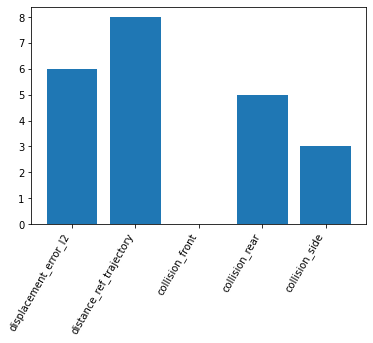

In [15]:
from src.validate.validator import CLEValidator
import matplotlib.pyplot as plt
import numpy as np

agg = CLEValidator(sim_outs)
fields = ["metric", "value"]
table = PrettyTable(field_names=fields)

values = []
names = []

for metric_name in agg:
    table.add_row([metric_name, agg[metric_name].item()])
    values.append(agg[metric_name].item())
    names.append(metric_name)

print(table)

plt.bar(np.arange(len(names)), values)
plt.xticks(np.arange(len(names)), names, rotation=60, ha='right')
plt.show()

In [ ]:
from src.validate.validator import CLEValidator
import matplotlib.pyplot as plt
import numpy as np

agg = CLEValidator(sim_outs)
fields = ["metric", "value"]
table = PrettyTable(field_names=fields)

values = []
names = []

for metric_name in agg:
    table.add_row([metric_name, agg[metric_name].item()])
    values.append(agg[metric_name].item())
    names.append(metric_name)

print(table)

plt.bar(np.arange(len(names)), values)
plt.xticks(np.arange(len(names)), names, rotation=60, ha='right')
plt.show()